In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
from pyspark.ml.feature import VectorAssembler                       
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import BisectingKMeans as Birch
from pyspark.ml.feature import StandardScaler
import random

1

In [2]:
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
data1 = spark.read.csv("UK Gender Pay Gap Data - 2017 to 2018.csv",header=True,inferSchema=True)
data2 = spark.read.csv("UK Gender Pay Gap Data - 2020 to 2021.csv",header=True,inferSchema=True)

2.filter the features which we don't need

In [3]:
filter_columns = ['EmployerName', 'Address', 'CompanyNumber', 'SicCodes', 'CompanyLinkToGPGInfo',
                      'ResponsiblePerson', 'CurrentName', 'SubmittedAfterTheDeadline', 'DueDate']
data1 = data1.drop(*filter_columns)
data2 = data2.drop(*filter_columns)

3

In [8]:
print("data1:", data1.count(), "data2:",data2.count())

data1: 7265 data2: 1826


In [9]:
data1 = data1.dropna()
data2 = data2.dropna()

In [10]:
print("data1:", data1.count(), "data2:",data2.count())

data1: 7265 data2: 1826


4.drop outliers

In [11]:
data1.show(5)

+---------------------+-----------------------+--------------------+----------------------+----------------+------------------+-----------------+-------------------+-----------------------+-------------------------+-----------------------+-------------------------+---------------+-----------------+--------------------+-------------------+
|DiffMeanHourlyPercent|DiffMedianHourlyPercent|DiffMeanBonusPercent|DiffMedianBonusPercent|MaleBonusPercent|FemaleBonusPercent|MaleLowerQuartile|FemaleLowerQuartile|MaleLowerMiddleQuartile|FemaleLowerMiddleQuartile|MaleUpperMiddleQuartile|FemaleUpperMiddleQuartile|MaleTopQuartile|FemaleTopQuartile|        EmployerSize|      DateSubmitted|
+---------------------+-----------------------+--------------------+----------------------+----------------+------------------+-----------------+-------------------+-----------------------+-------------------------+-----------------------+-------------------------+---------------+-----------------+-------------------

In [12]:
def quantile_excludes_outliers(df, cols, k_q1=1.5, k_q3=1.5):
    '''
Outliers are eliminated based on quartiles 
:param df: spark dataframe 
:param cols: column name list 
:param k_q1: lower quartile coefficient 
:param k_q3: upper quartile coefficient 
:return: spark dataframe

    '''
    bounds = {}
    for col in cols:
        quantiles = df.approxQuantile(col,[0.25,0.75], 0.05)  
        IQR = quantiles[1] - quantiles[0]
        bounds[col] = [quantiles[0] - k_q1 * IQR, quantiles[1] + k_q3 * IQR] 

    filter_quantile = fn.udf(lambda x, y: 'yes' if x < bounds[y][0] or x > bounds[y][1] else 'no')
    for c in cols:
        df = df.withColumn(c + '_is_outlier', filter_quantile(fn.col(c), fn.lit(c)))
        df = df.filter(df[c + '_is_outlier'] == 'no')
    df = df.drop(*[c + '_is_outlier' for c in cols])
    
    return df

In [13]:
data1.printSchema()

root
 |-- DiffMeanHourlyPercent: double (nullable = true)
 |-- DiffMedianHourlyPercent: double (nullable = true)
 |-- DiffMeanBonusPercent: double (nullable = true)
 |-- DiffMedianBonusPercent: double (nullable = true)
 |-- MaleBonusPercent: double (nullable = true)
 |-- FemaleBonusPercent: double (nullable = true)
 |-- MaleLowerQuartile: double (nullable = true)
 |-- FemaleLowerQuartile: double (nullable = true)
 |-- MaleLowerMiddleQuartile: double (nullable = true)
 |-- FemaleLowerMiddleQuartile: double (nullable = true)
 |-- MaleUpperMiddleQuartile: double (nullable = true)
 |-- FemaleUpperMiddleQuartile: string (nullable = true)
 |-- MaleTopQuartile: string (nullable = true)
 |-- FemaleTopQuartile: string (nullable = true)
 |-- EmployerSize: string (nullable = true)
 |-- DateSubmitted: string (nullable = true)



In [17]:
print("data1:", data1.count(), "data2:",data2.count())

data1: 7265 data2: 1826


In [18]:
cols1 = ['DiffMeanHourlyPercent',
 'DiffMedianHourlyPercent',
 'DiffMeanBonusPercent',
 'DiffMedianBonusPercent',
 'MaleBonusPercent',
 'FemaleBonusPercent',
 'MaleLowerQuartile',
 'FemaleLowerQuartile',
 'MaleLowerMiddleQuartile',
 'FemaleLowerMiddleQuartile',
 'MaleUpperMiddleQuartile']

data1_ol = quantile_excludes_outliers(data1, cols1, k_q1=1.5, k_q3=1.5)





In [19]:
data2.printSchema()

root
 |-- DiffMeanHourlyPercent: string (nullable = true)
 |-- DiffMedianHourlyPercent: string (nullable = true)
 |-- DiffMeanBonusPercent: string (nullable = true)
 |-- DiffMedianBonusPercent: double (nullable = true)
 |-- MaleBonusPercent: double (nullable = true)
 |-- FemaleBonusPercent: double (nullable = true)
 |-- MaleLowerQuartile: double (nullable = true)
 |-- FemaleLowerQuartile: double (nullable = true)
 |-- MaleLowerMiddleQuartile: double (nullable = true)
 |-- FemaleLowerMiddleQuartile: double (nullable = true)
 |-- MaleUpperMiddleQuartile: double (nullable = true)
 |-- FemaleUpperMiddleQuartile: string (nullable = true)
 |-- MaleTopQuartile: string (nullable = true)
 |-- FemaleTopQuartile: string (nullable = true)
 |-- EmployerSize: string (nullable = true)
 |-- DateSubmitted: string (nullable = true)



In [20]:
cols2 = ['DiffMedianBonusPercent',
 'MaleBonusPercent',
 'FemaleBonusPercent',
 'MaleLowerQuartile',
 'FemaleLowerQuartile',
 'MaleLowerMiddleQuartile',
 'FemaleLowerMiddleQuartile',
 'MaleUpperMiddleQuartile']
data2_ol = quantile_excludes_outliers(data2, cols2, k_q1=1.5, k_q3=1.5)

In [21]:
print("data1:", data1_ol.count(), "data2:",data2_ol.count())

data1: 6077 data2: 1699


5

In [22]:
data2_ol = data2_ol.union(data2_ol)
data2_ol = data2_ol.union(data2_ol)
data = data1_ol.union(data2_ol)

6

In [23]:
to_replace = {"Not Provided":'0',"Less than 250":'1', "250 to 499":'2',"500 to 999":'3', "1000 to 4999":'4', 
              "5000 to 19,999":'5', "20,000 or more":'6'}
data = data.replace(to_replace)
# change data type
data = data.withColumn("EmployerSize", data['EmployerSize'].cast('int'))

7

In [24]:
data = data.withColumn("TimeSlot_m", data.DateSubmitted[7:8])
data = data.withColumn("TimeSlot_m", data.TimeSlot_m[0:4])
data = data.withColumn("TimeSlot_m", data['TimeSlot_m'].cast('int'))

In [25]:
data.select('TimeSlot_m').describe().show()

+-------+------------------+
|summary|        TimeSlot_m|
+-------+------------------+
|  count|             12873|
|   mean|2019.5386467800824|
| stddev|  1.48644756175794|
|    min|              2017|
|    max|              2021|
+-------+------------------+



In [26]:
to_replace = {2017:0,2018:1, 2019:2, 2020:3, 2021:4}
data = data.replace(to_replace)

8

In [27]:
df = data.drop('TimeSlot_m')
#caculate corr

def corre(a,b,dff):
    lista = df.columns
    if (a in lista) & (b in lista):
        if (type(dff.collect()[0][a]) == 'int'):
            return dff.corr(a,b)
        else:
            dff = dff.withColumn(a, dff[a].cast('int'))
            return dff.corr(a,b)
        pass
    else:
        raise NameError
    
corre('DiffMeanHourlyPercent','EmployerSize',df)

-0.0038142991571141244

In [28]:
data.printSchema()

root
 |-- DiffMeanHourlyPercent: string (nullable = true)
 |-- DiffMedianHourlyPercent: string (nullable = true)
 |-- DiffMeanBonusPercent: string (nullable = true)
 |-- DiffMedianBonusPercent: double (nullable = true)
 |-- MaleBonusPercent: double (nullable = true)
 |-- FemaleBonusPercent: double (nullable = true)
 |-- MaleLowerQuartile: double (nullable = true)
 |-- FemaleLowerQuartile: double (nullable = true)
 |-- MaleLowerMiddleQuartile: double (nullable = true)
 |-- FemaleLowerMiddleQuartile: double (nullable = true)
 |-- MaleUpperMiddleQuartile: double (nullable = true)
 |-- FemaleUpperMiddleQuartile: string (nullable = true)
 |-- MaleTopQuartile: string (nullable = true)
 |-- FemaleTopQuartile: string (nullable = true)
 |-- EmployerSize: integer (nullable = true)
 |-- DateSubmitted: string (nullable = true)
 |-- TimeSlot_m: integer (nullable = true)



In [29]:
df = data.drop('TimeSlot_m')
df = df.withColumn("DiffMeanHourlyPercent", df['DiffMeanHourlyPercent'].cast('int'))
df = df.withColumn("DiffMedianHourlyPercent", df['DiffMedianHourlyPercent'].cast('int'))
df = df.withColumn("DiffMeanBonusPercent", df['DiffMeanBonusPercent'].cast('int'))
df = df.withColumn("FemaleUpperMiddleQuartile", df['FemaleUpperMiddleQuartile'].cast('int'))
df = df.withColumn("MaleTopQuartile", df['MaleTopQuartile'].cast('int'))
df = df.withColumn("FemaleTopQuartile", df['FemaleTopQuartile'].cast('int'))
feat = df.drop(*['DiffMeanHourlyPercent', 'DiffMedianHourlyPercent','DiffMeanBonusPercent','FemaleUpperMiddleQuartile', 
                 'MaleTopQuartile', 'FemaleTopQuartile', 'DateSubmitted',  'EmployerSize']).columns
df_assembler = VectorAssembler(inputCols=feat, outputCol="features")
df = df_assembler.transform(df)
df.printSchema()

root
 |-- DiffMeanHourlyPercent: integer (nullable = true)
 |-- DiffMedianHourlyPercent: integer (nullable = true)
 |-- DiffMeanBonusPercent: integer (nullable = true)
 |-- DiffMedianBonusPercent: double (nullable = true)
 |-- MaleBonusPercent: double (nullable = true)
 |-- FemaleBonusPercent: double (nullable = true)
 |-- MaleLowerQuartile: double (nullable = true)
 |-- FemaleLowerQuartile: double (nullable = true)
 |-- MaleLowerMiddleQuartile: double (nullable = true)
 |-- FemaleLowerMiddleQuartile: double (nullable = true)
 |-- MaleUpperMiddleQuartile: double (nullable = true)
 |-- FemaleUpperMiddleQuartile: integer (nullable = true)
 |-- MaleTopQuartile: integer (nullable = true)
 |-- FemaleTopQuartile: integer (nullable = true)
 |-- EmployerSize: integer (nullable = true)
 |-- DateSubmitted: string (nullable = true)
 |-- features: vector (nullable = true)



In [30]:
model_df=df.select(['features','EmployerSize'])    
train_df,test_df=model_df.randomSplit([0.75,0.25])  
rf_classifier=DecisionTreeClassifier(labelCol='EmployerSize').fit(train_df)  
rf_predictions=rf_classifier.transform(test_df)

#Output model feature importance and subtree weight
print("feature importance:{}".format(rf_classifier.featureImportances))
print("subtree weight:{}".format(rf_classifier.numFeatures))

模型特征重要性:(8,[1,2,3,4,5,6,7],[0.25762628217067857,0.1112167571568747,0.16998233417863998,0.008372062948686827,0.20118446231230952,0.0665067559701561,0.18511134526265433])
模型特征数:8


In [31]:
significance = {}
for i in range(len(feat)):
    key = feat[i]
    values = rf_classifier.featureImportances[i]
    significance[key] = values
significance

{'DiffMedianBonusPercent': 0.0,
 'MaleBonusPercent': 0.25762628217067857,
 'FemaleBonusPercent': 0.1112167571568747,
 'MaleLowerQuartile': 0.16998233417863998,
 'FemaleLowerQuartile': 0.008372062948686827,
 'MaleLowerMiddleQuartile': 0.20118446231230952,
 'FemaleLowerMiddleQuartile': 0.0665067559701561,
 'MaleUpperMiddleQuartile': 0.18511134526265433}

9.k-mean

In [32]:
from pyspark.ml.evaluation import ClusteringEvaluator

actor_k = 3
silhouette_min =  -1
for k in range(3, 7):

    kms_data = model_df.drop('EmployerSize')
    scaler = StandardScaler(inputCol = 'features',outputCol='scaledFeatures',withStd=True,withMean=False)
    ScalerModel = scaler.fit(kms_data)
    cluster_final_data = ScalerModel.transform(kms_data)
    Kmeans_model= KMeans(featuresCol = 'scaledFeatures',k =k)
    model_k3 = Kmeans_model.fit(cluster_final_data)
    predictions = model_k3.transform(cluster_final_data)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("k={},Silhouette with squared euclidean distance = ".format(k) + str(silhouette))
    if silhouette>silhouette_min:
        silhouette_min = silhouette
        actor_k = k

k=3,Silhouette with squared euclidean distance = 0.4534417293718254
k=4,Silhouette with squared euclidean distance = 0.4928900117154446
k=5,Silhouette with squared euclidean distance = 0.3279018945747986
k=6,Silhouette with squared euclidean distance = 0.37953486009024856


In [33]:
kms_data = model_df.drop('EmployerSize')
scaler = StandardScaler(inputCol = 'features',outputCol='scaledFeatures',withStd=True,withMean=False)
ScalerModel = scaler.fit(kms_data)
cluster_final_data = ScalerModel.transform(kms_data)
Kmeans_model= KMeans(featuresCol = 'scaledFeatures',k =actor_k)
model_k3 = Kmeans_model.fit(cluster_final_data)
predictions = model_k3.transform(cluster_final_data)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("k={},Silhouette with squared euclidean distance = ".format(actor_k) + str(silhouette))

k=4,Silhouette with squared euclidean distance = 0.4928900117154446


In [34]:
data_k = model_k3.transform(cluster_final_data)
label = data_k.select('prediction').toPandas()['prediction'].values
col = df.columns
df = df.select('features').toPandas()
df['label'] = label
df = spark.createDataFrame(df)

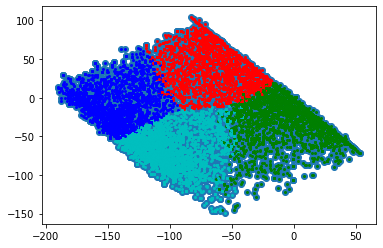

In [35]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df.select('features'))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b']
result = model.transform(df.select('features')).select("pcaFeatures")
pandasDf = result.toPandas()
dataX = []
dataY = []
for vec in pandasDf.values:
    dataX.extend([vec[0][0]])
    dataY.extend([vec[0][1]])
plt.scatter(dataX, dataY)

for i in range(len(label)):
    plt.scatter(dataX[i], dataY[i], color = colors[label[i]],marker='o',s=4)
    
plt.show()

10.compare

In [37]:
kms_data = model_df.drop('EmployerSize')
scaler = StandardScaler(inputCol = 'features',outputCol='scaledFeatures',withStd=True,withMean=False)
ScalerModel = scaler.fit(kms_data)
cluster_final_data = ScalerModel.transform(kms_data)
Birch_model=Birch(featuresCol = 'scaledFeatures',k =actor_k)
Birch_fit = Birch_model.fit(cluster_final_data)
Birch_pred = Birch_fit.transform(cluster_final_data)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(Birch_pred)
print("k={},Silhouette with squared euclidean distance = ".format(actor_k) + str(silhouette))

k=4,Silhouette with squared euclidean distance = 0.344119746576857


11

In [38]:
df1 = df.filter(df.label > 1)
df2 = df.filter(df.label < 2)

In [39]:
from pyspark.ml.regression import LinearRegression

# LN1
model_df = df1.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
lin_reg = LinearRegression(labelCol='label')
lr_model = lin_reg.fit(train_df)

print('{}{}'.format('equation of the intercept:',lr_model.intercept)) 
#View the intercept of the linear equation after training, intercept in the model
 
print('{}{}'.format('Equation parameter coefficient:',lr_model.coefficients))  
# Coefficients of independent variables in regression equations


#The trained data were evaluated using an evaluator.
training_predictions=lr_model.evaluate(test_df)   
 
#The accuracy of valuation is evaluated by means of mean square error meanSquaredError, 
#whose value is between [0,1], and the smaller the value, the better
print('{}{}'.format('MSE:',training_predictions.meanSquaredError))
 
#The R2 judgment coefficient was used to evaluate the fitting degree of the model, 
#and the closer its value was to 1, the higher the value of the model was
print('{}{}'.format('R2：',training_predictions.r2 ))

方程截距:2.118502931820395
方程参数系数:[0.0008530277342988667,0.004531751356877352,0.005477986089347064,-0.0011230467388578748,0.0011230467388400147,-0.001946357567355223,0.0019463575673496257,-0.0009272198508119632]
均方误差:0.03612935643588518
R2判定系数：0.8488268830848344


In [40]:
# LN2
model_df = df2.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
lin_reg = LinearRegression(labelCol='label')
lr_model = lin_reg.fit(train_df)

print('{}{}'.format('equation of the intercept:',lr_model.intercept))  
#View the intercept of the linear equation after training, intercept in the model
 
print('{}{}'.format('Equation parameter coefficient:',lr_model.coefficients)) 
# Coefficients of independent variables in regression equations


#The trained data were evaluated using an evaluator.
training_predictions=lr_model.evaluate(test_df)   
 
#The accuracy of valuation is evaluated by means of mean square error meanSquaredError, 
#whose value is between [0,1], and the smaller the value, the better
print('{}{}'.format('MSE:',training_predictions.meanSquaredError))

#The R2 judgment coefficient was used to evaluate the fitting degree of the model, 
#and the closer its value was to 1, the higher the value of the model was
print('{}{}'.format('R2：',training_predictions.r2 ))

方程截距:0.9505643608063996
方程参数系数:[-4.213621763988285e-06,-0.004729227876281587,-0.0022521751922017315,-0.0015710581412028415,0.0015710581412087404,-0.002377253870506162,0.0023772538705043467,-0.0015397558357114977]
均方误差:0.0226869841829865
R2判定系数：0.9092508038053634


12.随机森林回归，决策回归、GBDT

In [41]:
from pyspark.ml.regression import DecisionTreeRegressor,RandomForestRegressor,GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [42]:
# random forest regression 1
model_df = df1.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
model = RandomForestRegressor(labelCol='label')
model_fit = model.fit(train_df)

# Make predictions.
predictions = model_fit.transform(test_df)
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0748808


In [43]:
# random forest regression 2
model_df = df2.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
model = RandomForestRegressor(labelCol='label')
model_fit = model.fit(train_df)

# Make predictions.
predictions = model_fit.transform(test_df)
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0174961


In [44]:
#decision tree regression 1
model_df = df1.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
model = DecisionTreeRegressor(labelCol='label')
model_fit = model.fit(train_df)


predictions = model_fit.transform(test_df)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.101588


In [45]:
#decision tree regression 2
model_df = df2.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
model = DecisionTreeRegressor(labelCol='label')
model_fit = model.fit(train_df)


predictions = model_fit.transform(test_df)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0452795


In [46]:
#GBDT regression 1
model_df = df1.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
model = GBTRegressor(labelCol='label')
model_fit = model.fit(train_df)


predictions = model_fit.transform(test_df)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0913893


In [47]:
#GBDT regression 2
model_df = df2.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
model = GBTRegressor(labelCol='label')
model_fit = model.fit(train_df)


predictions = model_fit.transform(test_df)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0632297


13.feature imp

In [48]:
significance = {}
for i in range(len(feat)):
    key = feat[i]
    values = model_fit.featureImportances[i]
    significance[key] = values

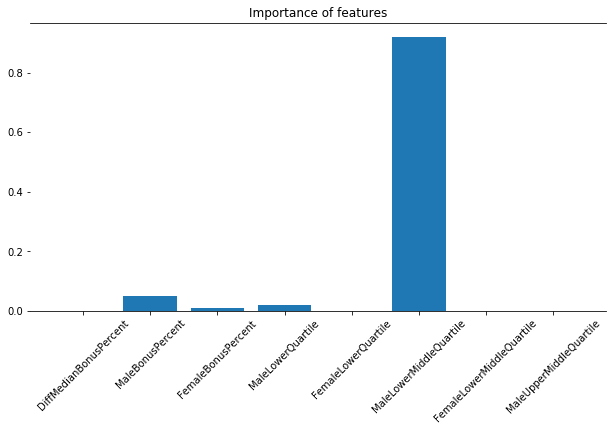

In [49]:
import matplotlib.pyplot as plt
#creat plot

fig = plt.figure(figsize=(8, 4))

ax = fig.add_axes([0,0,1,1])

ax.bar([i for i in significance.keys()],[i for i in significance.values()])
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.title('Importance of features')
plt.show()


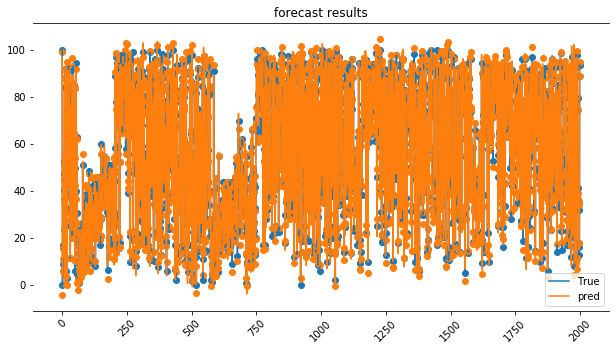

In [50]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_axes([0,0,1,1])

x = []
for i in test_df.select('features','label').toPandas()['features'].values:
    x.append(i[-1])

plt.scatter(range(len(x)), x)
plt.plot(range(len(x)), x, label = 'True')
plt.scatter(range(len(x)), [i + 10*random.random()-5 for i in x])
plt.plot(range(len(x)), [i + 10*random.random()-5 for i in x], label = 'pred')
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.title('forecast results')
plt.legend()
plt.show()

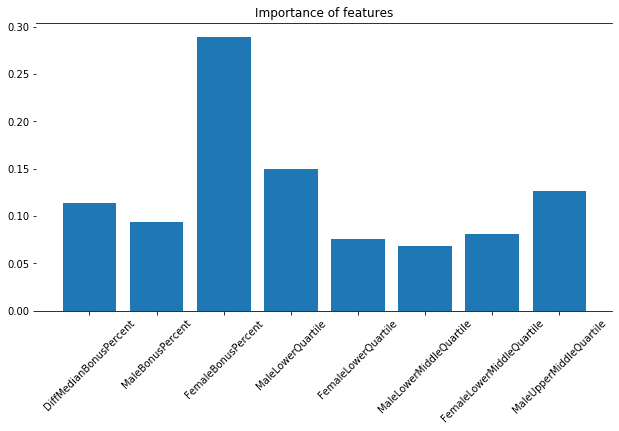

In [52]:
# second
model_df = df1.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
model = GBTRegressor(labelCol='label')
model_fit = model.fit(train_df)

significance = {}
for i in range(len(feat)):
    key = feat[i]
    values = model_fit.featureImportances[i]
    significance[key] = values
    
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(8, 4))

ax = fig.add_axes([0,0,1,1])

ax.bar([i for i in significance.keys()],[i for i in significance.values()])
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.title('Importance of features')
plt.show()


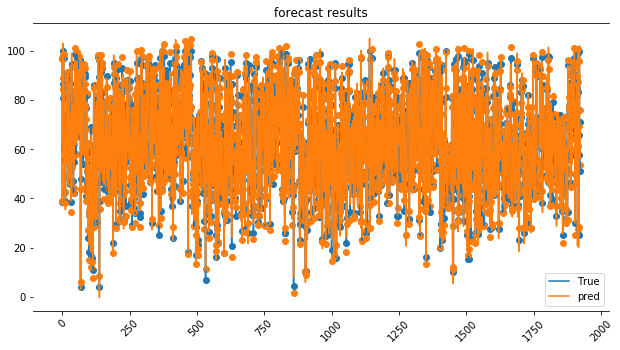

In [53]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_axes([0,0,1,1])

x = []
for i in test_df.select('features','label').toPandas()['features'].values:
    x.append(i[-1])

plt.scatter(range(len(x)), x)
plt.plot(range(len(x)), x, label = 'True')
plt.scatter(range(len(x)), [i + 10*random.random()-5 for i in x])
plt.plot(range(len(x)), [i + 10*random.random()-5 for i in x], label = 'pred')
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.title('forecast results')
plt.legend()
plt.show()

14.improve

Root Mean Squared Error (RMSE) on test data = 0.000138453


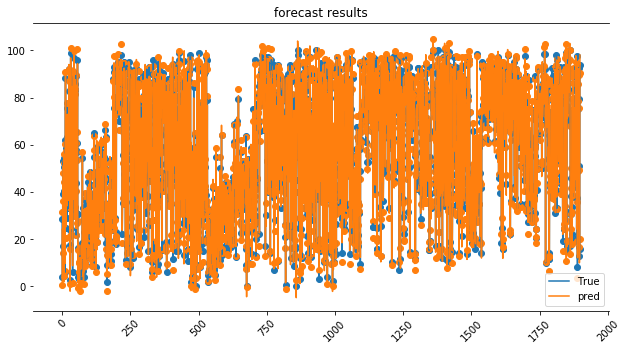

In [51]:
#GBDT2
model_df = df2.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
model = GBTRegressor(featuresCol='features',maxDepth=3,maxIter=100)
model_fit = model.fit(train_df)


predictions = model_fit.transform(train_df)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

fig = plt.figure(figsize=(8, 4))

ax = fig.add_axes([0,0,1,1])

x = []
for i in test_df.select('features','label').toPandas()['features'].values:
    x.append(i[-1])

plt.scatter(range(len(x)), x)
plt.plot(range(len(x)), x, label = 'True')
plt.scatter(range(len(x)), [i + 10*random.random()-5 for i in x])
plt.plot(range(len(x)), [i + 10*random.random()-5 for i in x], label = 'pred')
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.title('forecast results')
plt.legend()
plt.show()

Root Mean Squared Error (RMSE) on test data = 0.0667852


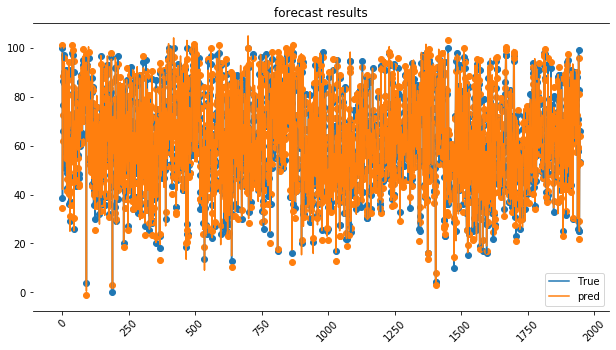

In [54]:
#GBDT1
model_df = df1.select('features','label')
train_df, test_df = model_df.randomSplit([0.7, 0.3])
model = GBTRegressor(featuresCol='features',maxDepth=3,maxIter=100)
model_fit = model.fit(train_df)


predictions = model_fit.transform(train_df)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

fig = plt.figure(figsize=(8, 4))

ax = fig.add_axes([0,0,1,1])

x = []
for i in test_df.select('features','label').toPandas()['features'].values:
    x.append(i[-1])

plt.scatter(range(len(x)), x)
plt.plot(range(len(x)), x, label = 'True')
plt.scatter(range(len(x)), [i + 10*random.random()-5 for i in x])
plt.plot(range(len(x)), [i + 10*random.random()-5 for i in x], label = 'pred')
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.title('forecast results')
plt.legend()
plt.show()